<pre>
  ______             _                _    _               
 |  ____|           | |              | |  (_)              
 | |__ __   __ __ _ | | _   _   __ _ | |_  _   ___   _ __  
 |  __|\ \ / // _` || || | | | / _` || __|| | / _ \ | '_ \ 
 | |____\ V /| (_| || || |_| || (_| || |_ | || (_) || | | |
 |______|\_/  \__,_||_| \__,_| \__,_| \__||_| \___/ |_| |_|
                                                           
                                                           
</pre>

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from io import BytesIO
import torch
import mmcv
from mmseg.apis import inference_segmentor
from mmseg.apis import init_segmentor
from mmseg.ops import resize
import os
import sys
from glob import glob

current_dir = os.path.dirname("__file__")
head_dir = os.path.join(current_dir, "../../benchmarking/SegVit_test_2", "decode_heads")
sys.path.append(head_dir)
import atm_head, tpn_atm_head

# losses (atm_loss)
head_dir = os.path.join(current_dir, "../../benchmarking/SegVit_test_2", "losses")
sys.path.append(head_dir)
import atm_loss


ModuleNotFoundError: No module named 'mmcv'

In [2]:
VIDEO_GAIMERSHEIM = sorted(glob('../dataset/camera_lidar/20180810_150607/camera/cam_front_center/*.png'))

# Functions

In [3]:
def calc_metrics(arr):
    mean = np.mean(arr)
    median = np.median(arr)
    std_dev = np.std(arr)
    variance = np.var(arr)
    min_val = np.min(arr)
    max_val = np.max(arr)
    range_val = np.ptp(arr)  # Range (max - min)
    sum_val = np.sum(arr)
    count = len(arr)  # Number of elements
    
    # Display results
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Variance: {variance}")
    print(f"Minimum: {min_val}")
    print(f"Maximum: {max_val}")
    print(f"Range: {range_val}")
    print(f"Sum: {sum_val}")
    print(f"Count: {count}")

# Benchmarking of the current architecture

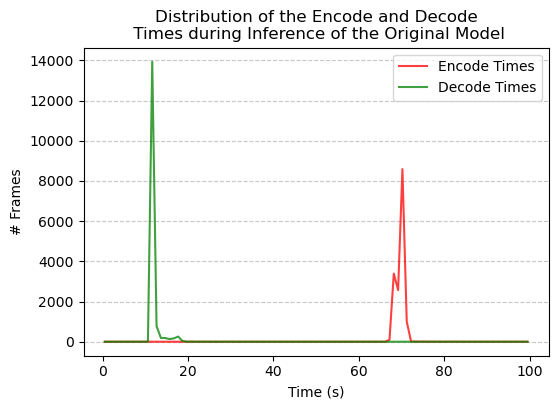

In [8]:
encode_times = np.load('benchmarking/model_og_encode_times_gpu.npy') * 1000
decode_times = np.load('benchmarking/model_og_decode_times_gpu.npy') * 1000

datasets = [encode_times[:15688], decode_times[:15688]]
labels = ["Encode Times", "Decode Times"]
colors = ['red', 'green']

plt.figure(figsize=(6, 4))

bins = np.linspace(0, 0.1*1000, 100)

for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Distribution of the Encode and Decode\n Times during Inference of the Original Model")
plt.xlabel("Time (ms)")
plt.ylabel("# Frames")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

In [6]:
calc_metrics(encode_times)
calc_metrics(encode_times)

Mean: 69.6955374282942
Median: 69.98682022094727
Standard Deviation: 2.1087450932683276
Variance: 4.446805868383248
Minimum: 67.00444221496582
Maximum: 404.0672779083252
Range: 337.0628356933594
Sum: 2186767.1823501587
Count: 31376
Mean: 0.0696955374282942
Median: 0.06998682022094727
Standard Deviation: 0.002108745093268328
Variance: 4.4468058683832486e-06
Minimum: 0.06700444221496582
Maximum: 0.4040672779083252
Range: 0.3370628356933594
Sum: 2186.7671823501587
Count: 31376


In [9]:
calc_metrics(decode_times)

Mean: 11.911688365843878
Median: 11.600017547607422
Standard Deviation: 1.1742063989307183
Variance: 1.3787606672898451
Minimum: 11.029243469238281
Maximum: 70.25909423828125
Range: 59.22985076904297
Sum: 373741.13416671753
Count: 31376


# Experiments
## Varying Thresholds for Cosine Similarity

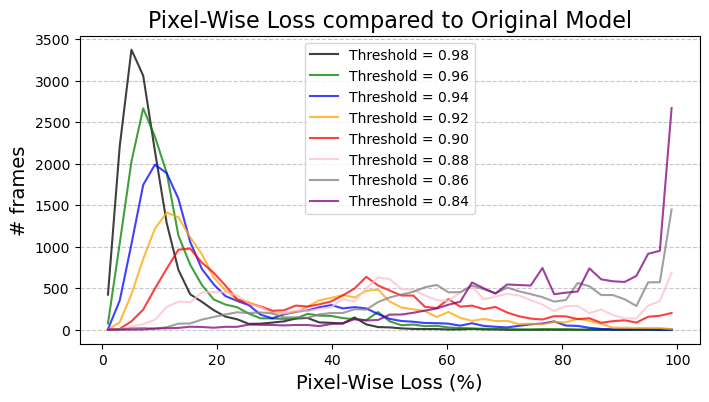

In [6]:
# Load the data
acc_98 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.98.npy')
acc_96 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.96.npy')
acc_94 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.94.npy')
acc_92 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.92.npy')
acc_90 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.9.npy')
acc_88 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.88.npy')
acc_86 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.86.npy')
acc_84 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.84.npy')

# Prepare the data for histogram line plots
datasets = [acc_98, acc_96, acc_94, acc_92, acc_90, acc_88, acc_86, acc_84]
labels = ["Threshold = 0.98", "Threshold = 0.96", "Threshold = 0.94", "Threshold = 0.92", "Threshold = 0.90", "Threshold = 0.88", "Threshold = 0.86", "Threshold = 0.84"]
colors = ['black', 'green', 'blue', 'orange', 'red', 'pink', 'gray', 'purple']

# Set up the plot
plt.figure(figsize=(8, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 100, 50)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Pixel-Wise Loss compared to Original Model", fontsize=16)
plt.xlabel("Pixel-Wise Loss (%)", fontsize=14)
plt.ylabel("# frames", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()


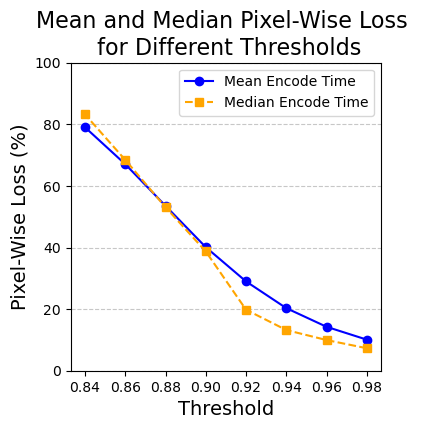

In [7]:
# Load the datasets
thresholds = [0.98, 0.96, 0.94, 0.92, 0.90, 0.88, 0.86, 0.84]
encode_times = {
    threshold: np.load(f'/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_{threshold}.npy')
    for threshold in thresholds
}

# Calculate mean and median for each threshold
means = [np.mean(encode_times[threshold]) for threshold in thresholds]
medians = [np.median(encode_times[threshold]) for threshold in thresholds]

# Plot mean and median
plt.figure(figsize=(4,4))
plt.plot(thresholds, means, label="Mean Encode Time", marker='o', linestyle='-', color='blue')
plt.plot(thresholds, medians, label="Median Encode Time", marker='s', linestyle='--', color='orange')

# Formatting the plot
plt.title("Mean and Median Pixel-Wise Loss \n for Different Thresholds", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Pixel-Wise Loss (%)", fontsize=14)
plt.ylim(0,100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(thresholds)  # Ensure all thresholds are labeled on the x-axis

# Show the plot
plt.show()

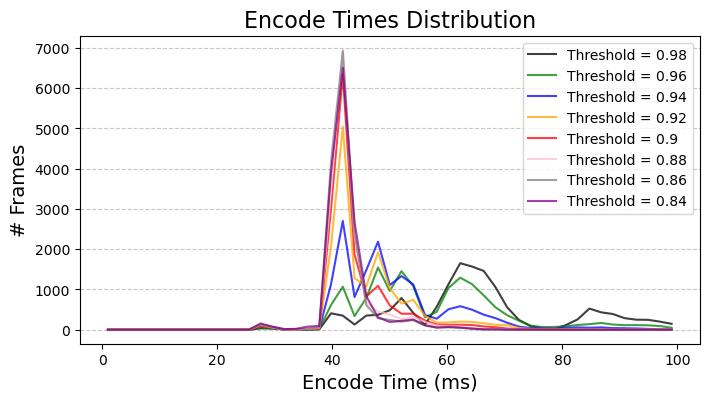

In [16]:
thresholds = [0.98, 0.96, 0.94, 0.92, 0.90, 0.88, 0.86, 0.84]
encode_times = {
    threshold: np.load(f'/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_all_layers_{threshold}.npy') * 1000
    for threshold in thresholds
}

labels = [f"Threshold = {threshold}" for threshold in thresholds]
colors = ['black', 'green', 'blue', 'orange', 'red', 'pink', 'gray', 'purple']
datasets = [encode_times[threshold] for threshold in thresholds]

# Set up the plot
plt.figure(figsize=(8, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 0.1*1000, 50)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Encode Times Distribution", fontsize=16)
plt.xlabel("Encode Time (ms)", fontsize=14)
plt.ylabel("# Frames", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

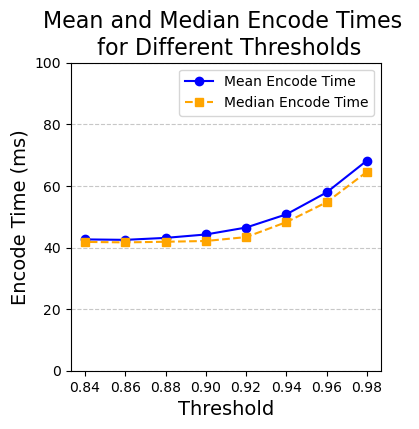

In [15]:
# Load the datasets
thresholds = [0.98, 0.96, 0.94, 0.92, 0.90, 0.88, 0.86, 0.84]
encode_times = {
    threshold: np.load(f'/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_all_layers_{threshold}.npy') * 1000
    for threshold in thresholds
}

# Calculate mean and median for each threshold
means = [np.mean(encode_times[threshold]) for threshold in thresholds]
medians = [np.median(encode_times[threshold]) for threshold in thresholds]

# Plot mean and median
plt.figure(figsize=(4, 4))
plt.plot(thresholds, means, label="Mean Encode Time", marker='o', linestyle='-', color='blue')
plt.plot(thresholds, medians, label="Median Encode Time", marker='s', linestyle='--', color='orange')

# Formatting the plot
plt.title("Mean and Median Encode Times \n for Different Thresholds", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Encode Time (ms)", fontsize=14)
plt.ylim(0,0.1*1000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(thresholds)  # Ensure all thresholds are labeled on the x-axis

# Show the plot
plt.show()


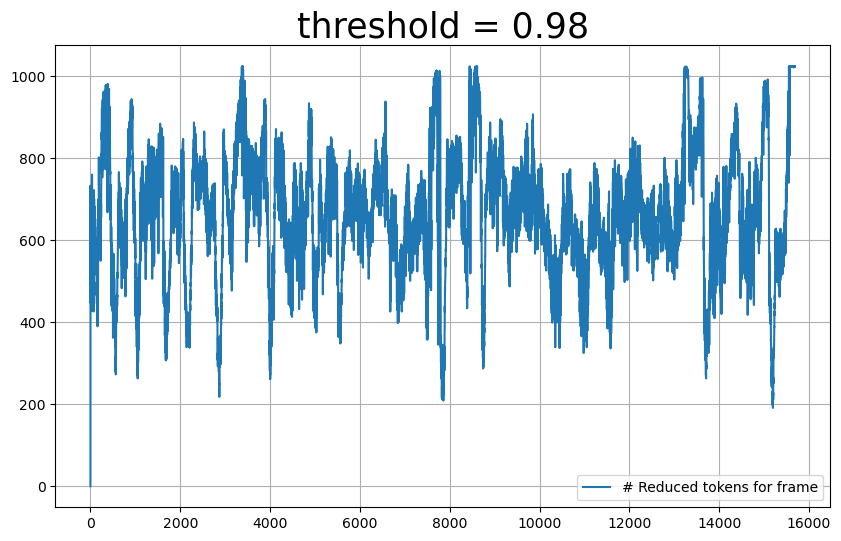

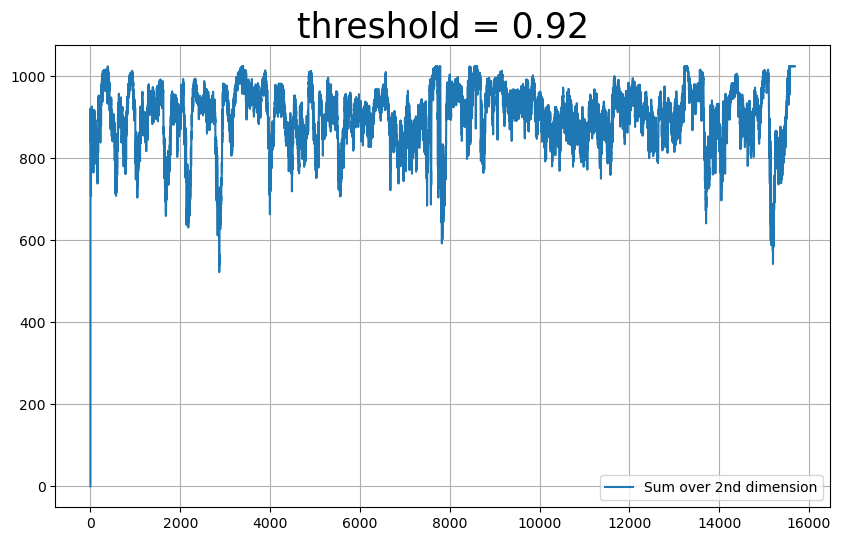

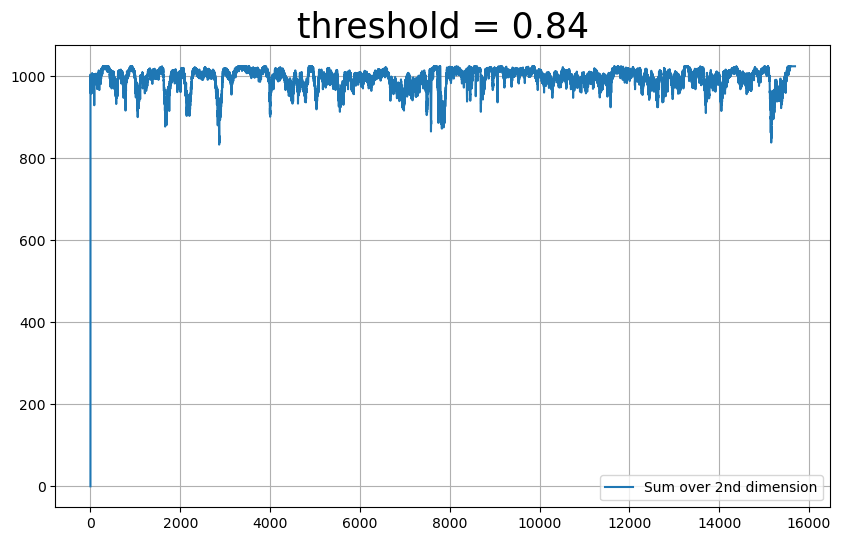

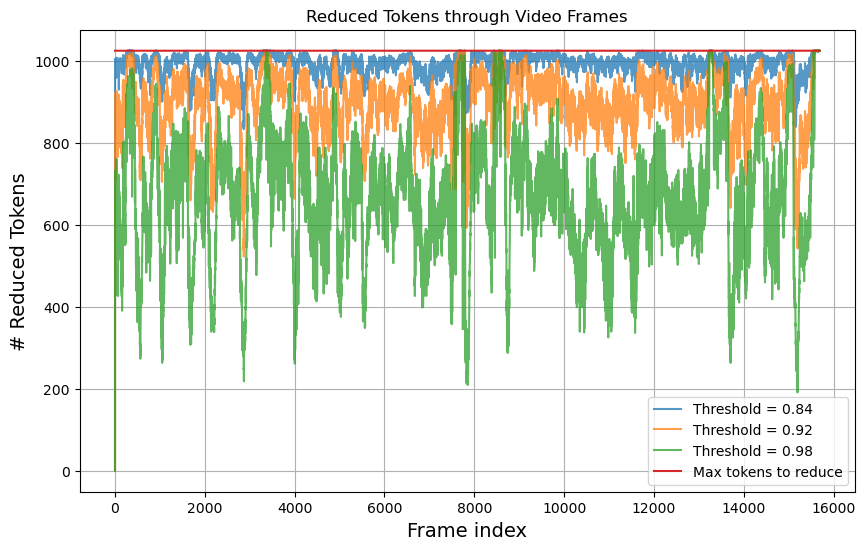

In [10]:
tokens_pruned_98 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/tokens_pruned_all_layers_0.98.npy')
tokens_pruned_98 = np.sum(tokens_pruned_98, axis=1)

# Plot the sums as a line chart
plt.figure(figsize=(10, 6))
plt.plot(tokens_pruned_98, label='# Reduced tokens for frame')
plt.title('threshold = 0.98',  fontsize=25)
plt.legend()
plt.grid()
plt.show()

tokens_pruned_92 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/tokens_pruned_all_layers_0.92.npy')
tokens_pruned_92 = np.sum(tokens_pruned_92, axis=1)

# Plot the sums as a line chart
plt.figure(figsize=(10, 6))
plt.plot(tokens_pruned_92, label='Sum over 2nd dimension')
plt.title('threshold = 0.92',  fontsize=25)
plt.legend()
plt.grid()
plt.show()


tokens_pruned_84 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/tokens_pruned_all_layers_0.84.npy')
tokens_pruned_84 = np.sum(tokens_pruned_84, axis=1)

# Plot the sums as a line chart
plt.figure(figsize=(10, 6))
plt.plot(tokens_pruned_84, label='Sum over 2nd dimension')
# plt.xlabel('Index of the 1st Dimension')
# plt.ylabel('Sum of the 2nd Dimension')
plt.title('threshold = 0.84',  fontsize=25)
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))

plt.plot(tokens_pruned_84, label='Threshold = 0.84', alpha=0.75)
plt.plot(tokens_pruned_92, label='Threshold = 0.92',alpha=0.75)
plt.plot(tokens_pruned_98, label='Threshold = 0.98', alpha=0.75)
plt.plot([1024] * len(tokens_pruned_84), label='Max tokens to reduce', alpha=1)
plt.title('Reduced Tokens through Video Frames')
plt.xlabel("Frame index", fontsize=14)
plt.ylabel("# Reduced Tokens", fontsize=14)
plt.legend()
plt.grid()
plt.show()



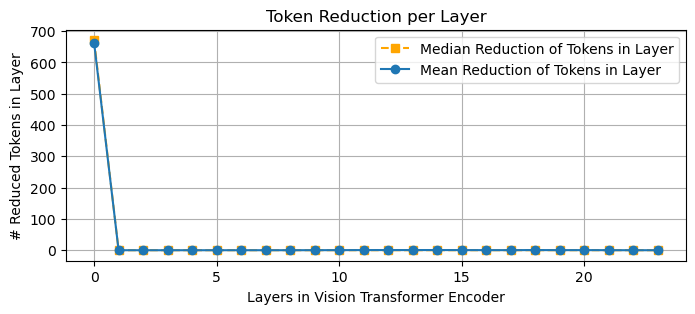

In [11]:
tokens_pruned = np.load('benchmarking/tokens_pruned_all_layers_0.98.npy')

column_averages = np.mean(tokens_pruned, axis=0)
column_median = np.median(tokens_pruned, axis=0)

plt.figure(figsize=(8, 3))

plt.plot(column_median, label="Median Reduction of Tokens in Layer", marker='s', linestyle='--', color='orange')
plt.plot(column_averages, marker='o', label='Mean Reduction of Tokens in Layer')
plt.title('Token Reduction per Layer')
plt.xlabel('Layers in Vision Transformer Encoder')
plt.ylabel('# Reduced Tokens in Layer')
plt.legend()

plt.grid()
plt.show()

## Fixed vs lin threshold

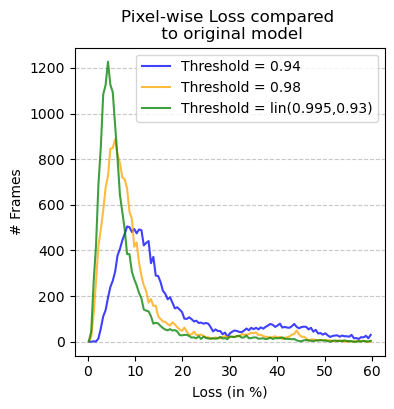

In [28]:
# Load the data
acc_94 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.94.npy')
acc_98 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_all_layers_0.98.npy')
acc_lin = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_lin_int_1.npy')

# Prepare the data for histogram line plots
datasets = [acc_94, acc_98, acc_lin]
labels = ["Threshold = 0.94", "Threshold = 0.98", "Threshold = lin(0.995,0.93)"]
colors = ['blue', 'orange', 'green']

# Set up the plot
plt.figure(figsize=(4, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 60, 120)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Pixel-wise Loss compared \n to original model")
plt.xlabel("Loss (in %)")
plt.ylabel("# Frames")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()


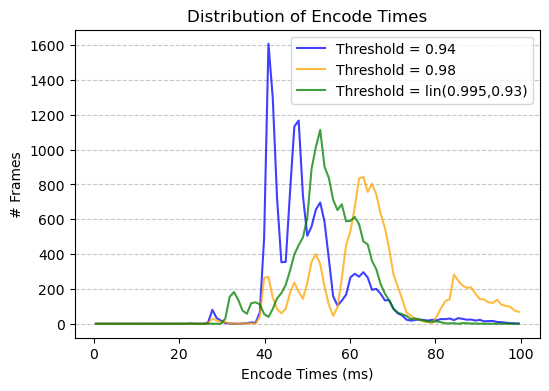

In [30]:
# Load the data
acc_94 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_all_layers_0.94.npy') * 1000
acc_98 = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_all_layers_0.98.npy') * 1000
acc_lin = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_lin_int_1.npy') * 1000

# Prepare the data for histogram line plots
datasets = [acc_94, acc_98, acc_lin]
labels = ["Threshold = 0.94", "Threshold = 0.98", "Threshold = lin(0.995,0.93)"]
colors = ['blue', 'orange', 'green']

# Set up the plot
plt.figure(figsize=(6, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 0.1*1000, 100)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Distribution of Encode Times")
plt.xlabel("Encode Times (ms)")
plt.ylabel("# Frames")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

## Different Reduction Intervals

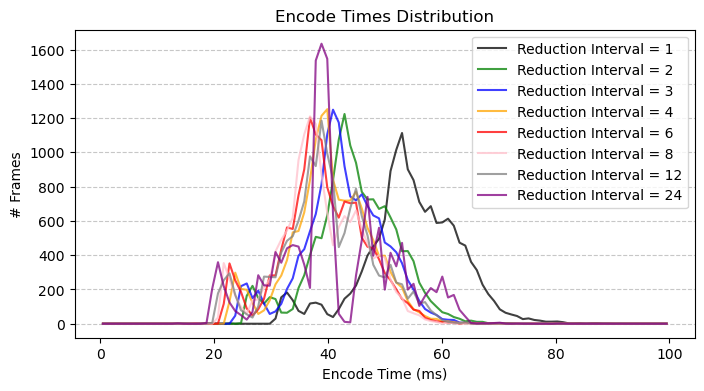

In [40]:
# Load the datasets
thresholds = [1,2,3,4,6,8,12,24]
encode_times = {
    threshold: np.load(f'/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_lin_int_{threshold}.npy') * 1000
    for threshold in thresholds
}

# Prepare the data for histogram line plots
labels = [f"Reduction Interval = {threshold}" for threshold in thresholds]
colors = ['black', 'green', 'blue', 'orange', 'red', 'pink', 'gray', 'purple']
datasets = [encode_times[threshold] for threshold in thresholds]

# Set up the plot
plt.figure(figsize=(8, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 0.1 * 1000, 100)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Encode Times Distribution")
plt.xlabel("Encode Time (ms)")
plt.ylabel("# Frames")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()


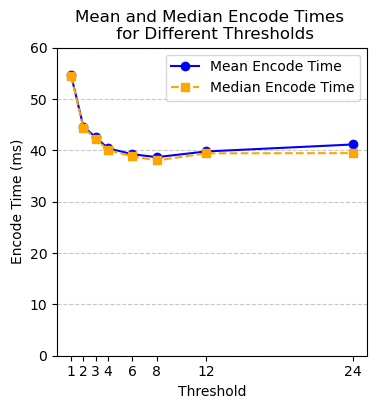

In [42]:
# Load the datasets
thresholds = [1,2,3,4,6,8,12,24]
encode_times = {
    threshold: np.load(f'/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_lin_int_{threshold}.npy') * 1000
    for threshold in thresholds
}

# Calculate mean and median for each threshold
means = [np.mean(encode_times[threshold]) for threshold in thresholds]
medians = [np.median(encode_times[threshold]) for threshold in thresholds]

# Plot mean and median
plt.figure(figsize=(4, 4))
plt.plot(thresholds, means, label="Mean Encode Time", marker='o', linestyle='-', color='blue')
plt.plot(thresholds, medians, label="Median Encode Time", marker='s', linestyle='--', color='orange')

# Formatting the plot
plt.title("Mean and Median Encode Times \n for Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Encode Time (ms)")
plt.ylim(0,0.06 * 1000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(thresholds)  # Ensure all thresholds are labeled on the x-axis

# Show the plot
plt.show()


## CPU times original vs optimized

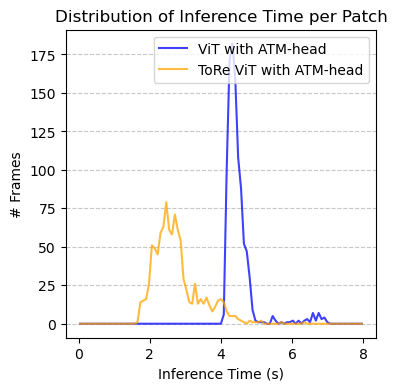

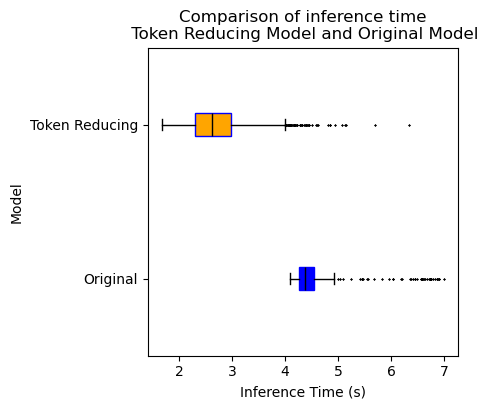

In [12]:
tore_decode_cpu = np.load('benchmarking/final_token_reducing_cpu_decode_times.npy')
tore_encode_cpu = np.load('benchmarking/final_token_reducing_cpu_encode_times.npy')

og_decode_cpu = np.load('benchmarking/og_cpu_decode_times.npy')
og_encode_cpu = np.load('benchmarking/og_cpu_encode_times.npy')

total_og = og_decode_cpu[:1000] + og_encode_cpu[:1000]
total_tore = tore_decode_cpu[:1000] + tore_encode_cpu[:1000]

datasets = [total_og, total_tore]
labels = ["ViT with ATM-head", "ToRe ViT with ATM-head"]
colors = ['blue', 'orange']

# Set up the plot
plt.figure(figsize=(4, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 8, 100)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Distribution of Inference Time per Patch")
plt.xlabel("Inference Time (s)")
plt.ylabel("# Frames")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(4, 4))
box = plt.boxplot(
    [total_og, total_tore],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    flierprops=dict(marker='x', color='red', markersize=1),
    medianprops=dict(color="black", linewidth=1),
)

# Customize colors for each box
colors = ['blue', 'orange']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
plt.yticks([1, 2], ["Original", "Token Reducing"])  # Set y-axis labels
plt.title("Comparison of inference time\n Token Reducing Model and Original Model")
plt.xlabel("Inference Time (s)")
plt.ylabel("Model")

# Show the plot
plt.show()

In [13]:
calc_metrics(total_tore)

Mean: 2.747318016767502
Median: 2.61663281917572
Standard Deviation: 0.6467716972546349
Variance: 0.41831362836964114
Minimum: 1.672161340713501
Maximum: 6.338454484939575
Range: 4.666293144226074
Sum: 2747.318016767502
Count: 1000


In [14]:
calc_metrics(total_og)

Mean: 4.492164814949036
Median: 4.381757020950317
Standard Deviation: 0.4535491241882109
Variance: 0.20570680805189318
Minimum: 4.0852038860321045
Maximum: 6.992705583572388
Range: 2.907501697540283
Sum: 4492.164814949036
Count: 1000


## GPU times original vs optimized

15688


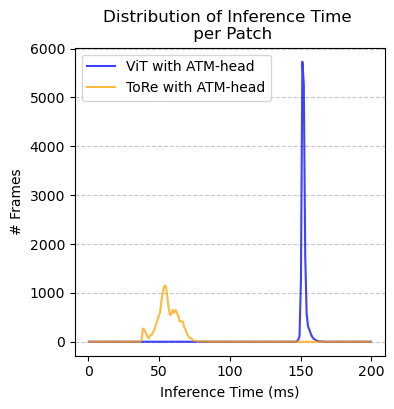

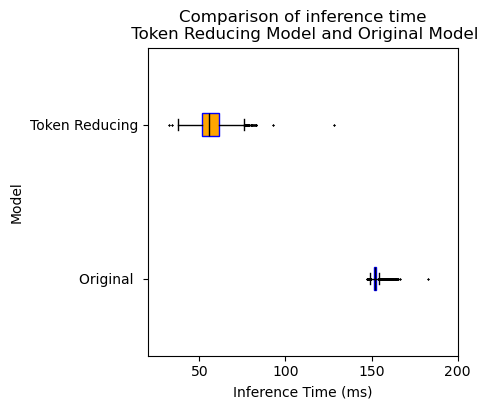

In [4]:
import numpy as np

encode_times_token_reduction_vision_transformer = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_lin_int_8.npy') * 1000

decode_times = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/model_og_decode_times_gpu.npy') * 1000
encode_times_vision_transformer = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/model_og_encode_times_gpu.npy') * 1000

print(len(encode_times_vision_transformer))

total_og = decode_times + encode_times_vision_transformer
total_tore = decode_times + encode_times_token_reduction_vision_transformer

datasets = [total_og, total_tore]
labels = ["ViT with ATM-head", "ToRe with ATM-head"]
colors = ['blue', 'orange']

# Set up the plot
plt.figure(figsize=(4, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 200, 200)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Distribution of Inference Time \n per Patch")
plt.xlabel("Inference Time (ms)")
plt.ylabel("# Frames")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(4, 4))
box = plt.boxplot(
    [total_og, total_tore],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    flierprops=dict(marker='x', color='red', markersize=1),
    medianprops=dict(color="black", linewidth=1),
)

# Customize colors for each box
colors = ['blue', 'orange']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
plt.yticks([1, 2], ["Original ", "Token Reducing"])  # Set y-axis labels
plt.title("Comparison of inference time\n Token Reducing Model and Original Model")
plt.xlabel("Inference Time (ms)")
plt.ylabel("Model")
plt.xlim(0.02*1000,200)

# Show the plot
plt.show()




In [47]:
calc_metrics(total_og)

Mean: 81.58763007568133
Median: 81.58421516418457
Standard Deviation: 3.4913839400471915
Variance: 12.18976181681945
Minimum: 78.62329483032227
Maximum: 474.32637214660645
Range: 395.7030773162842
Sum: 1279946.7406272888
Count: 15688


In [48]:
calc_metrics(total_tore)

Mean: 50.56632245942563
Median: 49.835801124572754
Standard Deviation: 7.593850543018633
Variance: 57.666566069704395
Minimum: 27.136802673339844
Maximum: 149.20663833618164
Range: 122.0698356628418
Sum: 793284.4667434692
Count: 15688


### Loss

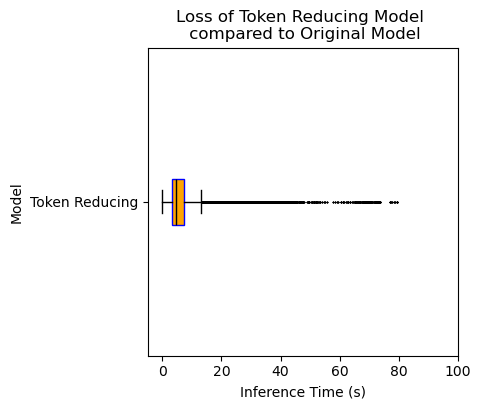

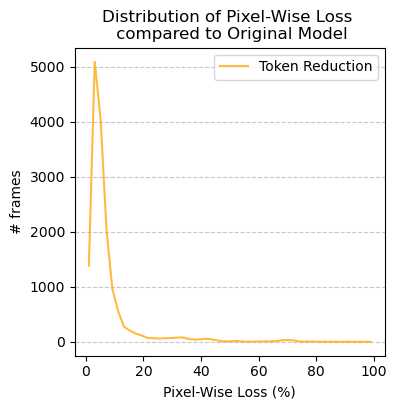

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
loss = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/pixel_wise_acc_list_lin_int_8.npy')

# Create the figure and the horizontal boxplots
plt.figure(figsize=(4, 4))
box = plt.boxplot(
    [loss],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    flierprops=dict(marker='x', color='red', markersize=1),
    medianprops=dict(color="black", linewidth=1),
)

# Customize colors for each box
colors = ['orange']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
plt.yticks([1], ["Token Reducing"])  # Set y-axis labels
plt.title("Loss of Token Reducing Model \n compared to Original Model")
plt.xlabel("Pixel-Wise Loss (%)")
plt.ylabel("Model")
plt.xlim(-5,100)

# Show the plot
plt.show()


# Prepare the data for histogram line plots
datasets = [loss]
labels = ["Token Reduction"]
colors = ['orange']

# Set up the plot
plt.figure(figsize=(4, 4))

# Generate and plot histogram data as lines
bins = np.linspace(0, 100, 50)  # Define bins (same for all datasets)
for data, label, color in zip(datasets, labels, colors):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    plt.plot(bin_centers, counts, label=label, color=color, alpha=0.75)

# Formatting the plot
plt.title("Distribution of Pixel-Wise Loss \n compared to Original Model")
plt.xlabel("Pixel-Wise Loss (%)")
plt.ylabel("# frames")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()


In [19]:
calc_metrics(loss)

Mean: 7.160264906847567
Median: 4.624523047234771
Standard Deviation: 8.965812076680557
Variance: 80.38578619435091
Minimum: 0.0
Maximum: 79.51659192579272
Range: 79.51659192579272
Sum: 112330.23585862463
Count: 15688


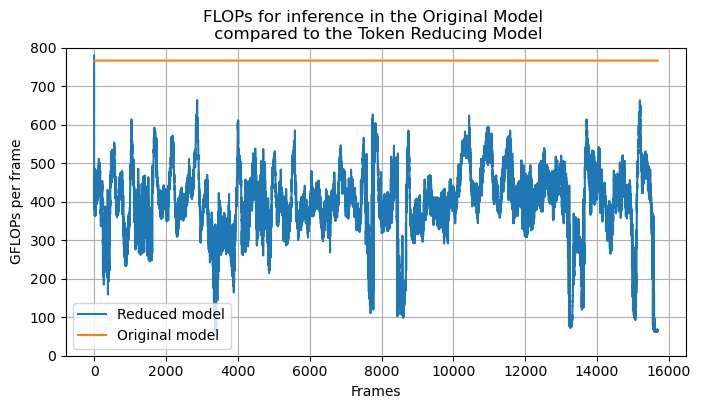

In [20]:
list_flops = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/final_model_flops.npy')

flops_og_model = 766613186156

list_flops_og = [flops_og_model] * len(list_flops)

list_flops_gflops = np.array(list_flops) / 1e9
list_flops_og_gflops = np.array(list_flops_og) / 1e9

plt.figure(figsize=(8, 4))
plt.plot(list_flops_gflops, label='Reduced model')
plt.plot(list_flops_og_gflops, label='Original model')
plt.title('FLOPs for inference in the Original Model \n compared to the Token Reducing Model')
plt.legend()
plt.xlabel("Frames")
plt.ylabel("GFLOPs per frame")
plt.ylim(0,800)
plt.grid()
plt.show()

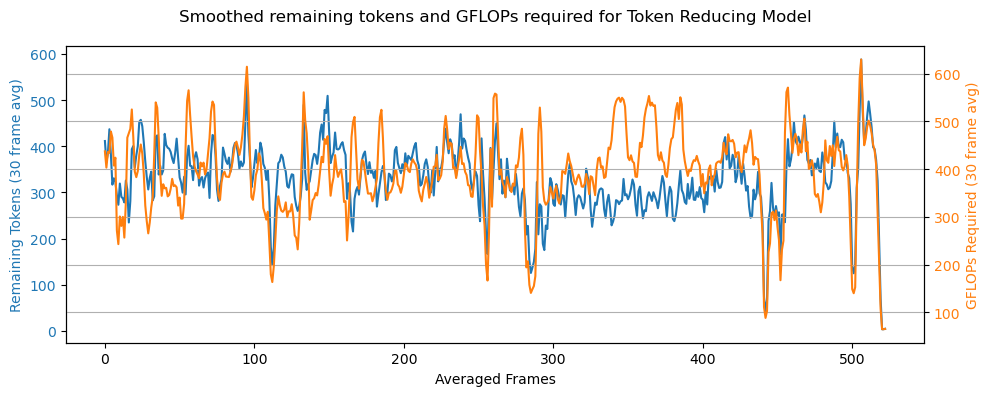

In [21]:

frames = np.arange(0, 15688)

gflops_required = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/final_model_flops.npy')

gflops_required = np.array(gflops_required) / 1e9

tokens_pruned = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/tokens_pruned_lin_int_8.npy')
tokens_pruned = np.sum(tokens_pruned, axis=1)

remaining_tokens = ([1024] * len(tokens_pruned)) - tokens_pruned


window_size = 30
remaining_tokens_avg = [
    np.mean(remaining_tokens[i:i + window_size]) for i in range(0, len(remaining_tokens), window_size)
]
gflops_required_avg = [
    np.mean(gflops_required[i:i + window_size]) for i in range(0, len(gflops_required), window_size)
]

fig, ax1 = plt.subplots(figsize=(10, 4))

color = 'tab:blue'
ax1.set_xlabel('Averaged Frames')
ax1.set_ylabel('Remaining Tokens (30 frame avg)', color=color)
ax1.plot(remaining_tokens_avg, label='Remaining Tokens (10-sec avg)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('GFLOPs Required (30 frame avg)', color=color)
ax2.plot(gflops_required_avg, label='GFLOPs Required (10-sec avg)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Smoothed remaining tokens and GFLOPs required for Token Reducing Model')
fig.tight_layout()

plt.grid()
plt.show()


## Frame Processing Speed and Vehicle Movement

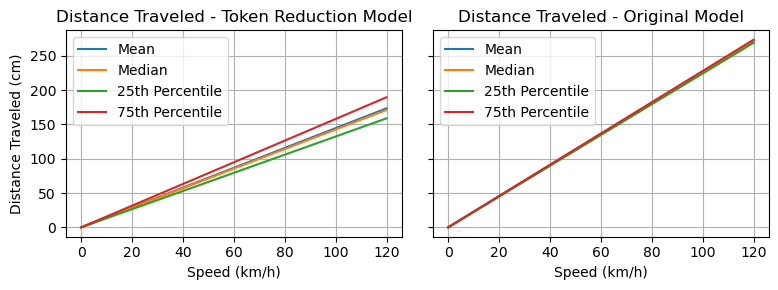

In [22]:

encode_times_token_reduction_vision_transformer = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/encode_times_lin_0.995_0.93.npy')
decode_times = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/model_og_decode_times_gpu.npy')
encode_times_vision_transformer = np.load('/project_ghent/woverbie/code/notebooks/benchmarking/model_og_encode_times_gpu.npy')


total_og = decode_times[:15688] + encode_times_vision_transformer[:15688]
total_tore = decode_times[:15688] + encode_times_token_reduction_vision_transformer[:15688]


mean_time_tore = np.mean(total_tore)
median_time_tore = np.median(total_tore)
p25_time_tore = np.percentile(total_tore, 25)
p75_time_tore = np.percentile(total_tore, 75)


mean_time_og = np.mean(total_og)
median_time_og = np.median(total_og)
p25_time_og = np.percentile(total_og, 25)
p75_time_og = np.percentile(total_og, 75)

# Speeds in km/h
speeds_kmh = np.linspace(0, 120, 500)

# Convert speeds to m/s
speeds_ms = speeds_kmh / 3.6

# Calculate distances traveled for each statistic
def calculate_distance(time):
    return speeds_ms * time * 100  # Convert to cm

distances_tore = {
    "Mean": calculate_distance(mean_time_tore),
    "Median": calculate_distance(median_time_tore),
    "25th Percentile": calculate_distance(p25_time_tore),
    "75th Percentile": calculate_distance(p75_time_tore),
}

distances_og = {
    "Mean": calculate_distance(mean_time_og),
    "Median": calculate_distance(median_time_og),
    "25th Percentile": calculate_distance(p25_time_og),
    "75th Percentile": calculate_distance(p75_time_og),
}

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot total_tore
axes[0].set_title("Distance Traveled - Token Reduction Model")
for label, distance in distances_tore.items():
    axes[0].plot(speeds_kmh, distance, label=label)
axes[0].set_xlabel("Speed (km/h)")
axes[0].set_ylabel("Distance Traveled (cm)")
axes[0].legend()
axes[0].grid(True)

# Plot total_og
axes[1].set_title("Distance Traveled - Original Model")
for label, distance in distances_og.items():
    axes[1].plot(speeds_kmh, distance, label=label)
axes[1].set_xlabel("Speed (km/h)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Tokens Matched

In [8]:
config_file = '../configs/token_reducing_config_gpu.py'
checkpoint_file = '../model/checkpoint/COCOstuff_49.9.pth'

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

r_values = np.linspace(0.995, 0.93, len(model.backbone.layers)).tolist()
for i, block in enumerate(model.backbone.layers):
    model.backbone.layers[i].r = r_values[i]


test_set = [VIDEO_GAIMERSHEIM[2124], VIDEO_GAIMERSHEIM[2125]]

for i, img_path in enumerate(test_set):
    
    result = inference_segmentor(model, img_path)

def load_image_from_url(file_path):
    img = Image.open(file_path)
    return img

def crop_to_center_square(img):
    width, height = img.size
    new_dimension = min(width, height)
    left = (width - new_dimension) / 2
    top = (height - new_dimension) / 2
    right = (width + new_dimension) / 2
    bottom = (height + new_dimension) / 2
    return img.crop((left, top, right, bottom))

def divide_into_patches(img, num_patches=1024):
    width, height = img.size
    
    patch_size = int(np.sqrt(width * height / num_patches))
    
    patches = []
    
    for i in range(0, width, patch_size):
        for j in range(0, height, patch_size):
            patch = img.crop((i, j, i + patch_size, j + patch_size))
            patches.append(patch)
    
    return patches

def process_image(url):
    img = load_image_from_url(url)
    
    img_cropped = crop_to_center_square(img)
    patches = divide_into_patches(img_cropped, num_patches=1024)
    
    return patches

def plot_two_patches(patch1, patch2):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    
    axes[0].imshow(patch1)
    axes[0].axis('off')
    axes[0].set_title('Current Patch')

    axes[1].imshow(patch2)
    axes[1].axis('off')
    axes[1].set_title('Matched Patch')

    plt.show()


patches_1 = process_image(test_set[0])
patches_2 = process_image(test_set[1])

for item in zip(model.backbone.layers[0].src_idx[0], model.backbone.layers[0].dst_idx[0]):

    plot_two_patches(patches_1[item[0].item()], patches_2[item[1].item()])


Initializing ATM head
load checkpoint from local path: ../model/checkpoint/COCOstuff_49.9.pth


KeyboardInterrupt: 